# Displaying q-learning results

This file was created to display some of the results from my exploration of q-learning on a simple chase game.
(note: required libraries listed in requirements.txt)

In [1]:
# Necesary imports
from src import chase
from matplotlib import style
import matplotlib.pyplot as plt
import pickle

style.use("ggplot")

## How it works
The `Env()` class is used to create a game environment, this environment icludes a "player" and "food" dot as well as a given number of "enemies". Note: to keep the game more interesting (and the q-table smaller), the player is only allowed to move diagonally. When creating the environment you choose (defaults):
- The model (if there is one prebuilt)
- Size of the board (10x10)
- Number of enemies (1)
- If enemies & food move (False) {if True, enemies and food will make random moves}
- Agent, Food and enemy colours as BGR triplets

In this environment, you can `.show(n)`, which will display n run throughs of the AI with the current q-table. Let us demonstrate by generating an environment with a fresh, random q-table and default paramaters. We can then watch how it performs (you may have to open the image window manually to view as it sometimes starts minimised).

In [2]:
game = chase.Env()
game.show(5)

Clearly this performs very badly as its q-table is random. To train a model, you can use `game.train(*args)`. This trains the model currently within the `game` environment, whether that be from scratch or training on top of a built model. The arguments to this function are all the normal training variables for RL\q-learning, which include but are not limited to; number of episodes, steps allowed, movement penalty, death penalty, epsilon, epsilon decay, leaning rate. It will also provide continuous updates on the rolling average and epsilon every `roll_avg` episodes, and also output a list of rolling averages which can be graphed. For example, training with default settings over 1000 episodes with updates every 100.

episode: 100, epsilon = 0.19940089012745543
100 ep mean: -502.75
episode: 200, epsilon = 0.19880357491810763
100 ep mean: -554.44
episode: 300, epsilon = 0.1982080489959546
100 ep mean: -605.31
episode: 400, epsilon = 0.1976143070010982
100 ep mean: -487.28
episode: 500, epsilon = 0.19702234358969614
100 ep mean: -539.32
episode: 600, epsilon = 0.19643215343391368
100 ep mean: -492.48
episode: 700, epsilon = 0.19584373122187632
100 ep mean: -530.09
episode: 800, epsilon = 0.19525707165762127
100 ep mean: -559.52
episode: 900, epsilon = 0.19467216946104998
100 ep mean: -506.69


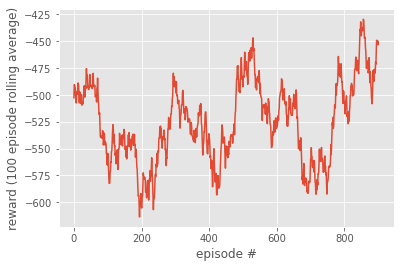

In [3]:
averages = game.train(episodes=1000, roll_avg=100)

plt.plot(range(len(averages)), averages)
plt.ylabel("reward (100 episode rolling average)")
plt.xlabel("episode #")
plt.show()

## Findings
It is clear from the graph above that to become sucessful, a model will need significantly more training. Below are the same rolling average graphs for two models, one trained in a static environment and one in a moving environment (`moving=True`). These were both trained over 1,000,000 episodes and display 5,000 episode rolling averages.

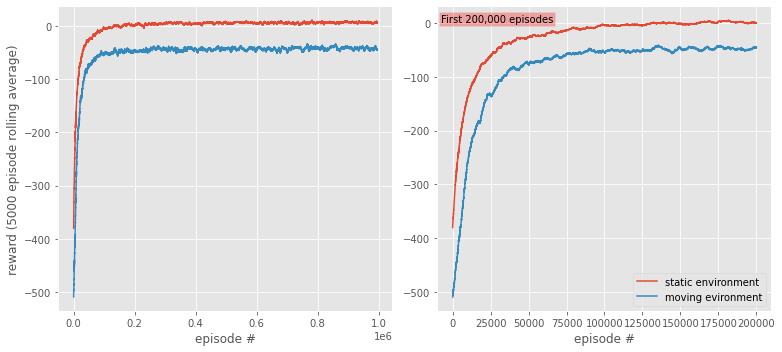

In [4]:
with open("src/1M_stationary_avgs.pickle", "rb") as f:
    static_avgs = pickle.load(f)
with open("src/1M_moving_avgs.pickle", "rb") as f:
    moving_avgs = pickle.load(f)
    
plt.rcParams['figure.figsize'] = [11, 5]

plt.subplot(1, 2, 1)
plt.plot(range(len(static_avgs)), static_avgs, label="static environment")
plt.plot(range(len(moving_avgs)), moving_avgs, label="moving evironment")
plt.ylabel("reward (5000 episode rolling average)")
plt.xlabel("episode #")

plt.subplot(1, 2, 2)
plt.plot(range(len(static_avgs[:200000])), static_avgs[:200000], label="static environment")
plt.plot(range(len(moving_avgs[:200000])), moving_avgs[:200000], label="moving evironment")
plt.xlabel("episode #")
plt.text(-8000, 1, "First 200,000 episodes", bbox={'facecolor': 'red', 'alpha': 0.3, 'pad': 2})

plt.tight_layout()
plt.legend()
plt.show()

You can easily see that just before around 100,000 episodes, both models seem to level off. Some fluctuations can still be seen in both (would also be more prominent given lower order rolling average), which means that with further refinement to the training parameters, maily learning rate, they could possibly increase more. However, this seems unnecesary, as both manage to stay comfortably above the winning threshold on average (above 300, since max number of moves is 300 by default and penalty for running into an enemy is 1000, therefore any failed attempts would score at least below 300). The agent trained in a moving environment levels off at a lower score, this makes sense as the food and enemy is moving in an unpredictable way, more total moves will be needed to succeed. Let us demonstrate a few episodes of these trained agesnts.

In [5]:
# Generate the static and moving environments with the pre-trained models
game_static = chase.Env(model="src/1Ms_model.pickle")
game_moving = chase.Env(model="src/1Mm_model.pickle", moving=True)

In [6]:
# Demonstrate the static and moving models
game_static.show(7)
game_moving.show(5)

Again, it is easy to see why the average score of the moving agent was lower. Because in the moving environment, it is more difficult for it to win due to the random nature of the other pieces moves. An interesting comparrison to make is thatof the performance of the stationary aagent in the moving game and vice versa. This can be done using the `test()` functionality of the environment, which allows you to test different models in the given environment (doesn't necessarily have to be model od a different environment, it can just be loaded in seperately). Note this may take a minute to run through 40,000 games.

In [7]:
# Generate data for both models in both environments
S_in_M = game_moving.test(game_static.qtable, 10000, 500)
M_in_M = game_moving.test(game_moving.qtable, 10000, 500)
S_in_S = game_static.test(game_static.qtable, 10000, 500)
M_in_S = game_static.test(game_moving.qtable, 10000, 500)

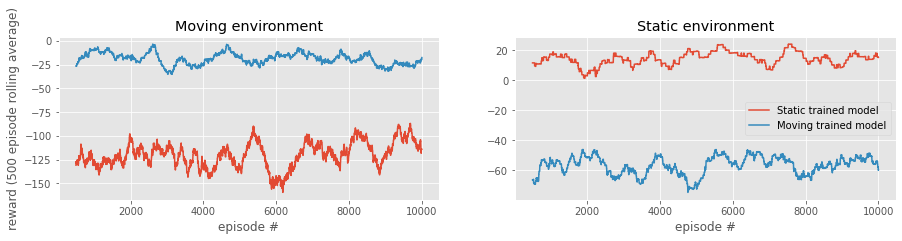

In [8]:
plt.rcParams['figure.figsize'] = [15, 3]

plt.subplot(1, 2, 1)
plt.plot(range(500, len(S_in_M)+500), S_in_M, label="Static trained model")
plt.plot(range(500, len(M_in_M)+500), M_in_M, label="Moving trained model")
plt.title("Moving environment")
plt.ylabel("reward (500 episode rolling average)")
plt.xlabel("episode #")

plt.subplot(1, 2, 2)
plt.plot(range(500, len(S_in_S)+500), S_in_S, label="Static trained model")
plt.plot(range(500, len(M_in_S)+500), M_in_S, label="Moving trained model")
plt.title("Static environment")
plt.xlabel("episode #")

plt.legend()
plt.show()

As expected, each model did significantly better in it's own environment. Note that here the barrier for success is above -50 as in the `test()` cases, only 50 steps are allowed. The static model doing badly in the moving environment is likely a result of it not expecing the enemy to move and therefore not trying as hard to avoid it. Part of the explanation could also be that when the food is not on the same diagonal, the static model has learned to go to an edge and attempt to move into it (causing it to move only in the one direction instead of diagonally) therfore, putting it on the other set of diagonals, then proceeding towards the food. This is obviously not necesary in a moving environment as one can just wait for the food to move and this "planning" behaviour could just cause the agent to be continually turning away from the food as it moves.

The moving model being worse in a static environmemnt is likely due to the same reasons. That is, because it expects the enemy to move, it would likely stay further away, and if the food is on the other set of diagonals, it will just wat for it to move.

One more thing that is possible is an environment with multiple enemies. In this situation, the model runs in the same way as before, but considering the "enemy" to be the enemy that is nearest to it. 

In [9]:
# Show off the static model with 5 enemies
game_static.change_enemies(5)
game_static.show(20)

In [10]:
# Generate data for both models in 5 enemy environment
static_5 = game_static.test(game_static.qtable, 10000, 500)
moving_5 = game_static.test(game_moving.qtable, 10000, 500)

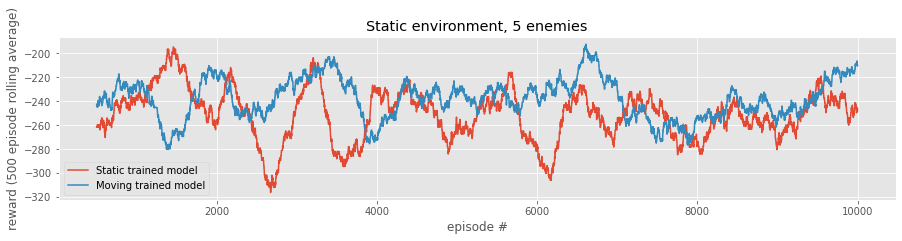

In [11]:
plt.plot(range(500, len(S_in_S)+500), static_5, label="Static trained model")
plt.plot(range(500, len(M_in_S)+500), moving_5, label="Moving trained model")
plt.title("Static environment, 5 enemies")
plt.xlabel("episode #")
plt.ylabel("reward (500 episode rolling average)")

plt.legend()
plt.show()

Here you can see that since the environemnt is unfamiliar to both models, they perform similarly. It may even be expected that the moving trained model be slightly better in this environemtn (as the above graph often shows). This is because it only considers the nearest enemy, so it would look as if the enemy is moving from one place to another, much like the moving environment it was trained in. Clearly both models will experience problems in the new environment that they would not have faced before, such as being stuck between two enemies. 

## Further work
This is as far as I explored when I originally created this project. I plan to eventually come back and complete more in depth optimization of the training paramaters, and even implement more sophisticated training, such as a decaying learning rate. I would also like to explore further into the comparrisons between the static and moving trained models, considering chaging things like the enemy penalty, so the moving model becomes less "scared" of the enemy and possibly create a better, more generalisable model for multiple enemies. Lastly, I would also like to consider the different ways of training a multi-enemy model to see what results they yield. This would include looking at:
- Training a model fully on multi-enemy environments.
- Pre-training a model on a single enemy environment (moving and/or static) then proceeding to train further with more enemies.
- Training on multi-enemy environments but consider different representations of the multiple enemies (instead of only considering the closest) for example:
    - Represent enemies as a combination of the n-nearest
    - Represent enemies as a density over the environment (how densely packed enemies are in given direction)